# Setup

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, fft
import math as math
import os
from matplotlib.patches import Polygon
import copy

## load data

In [2]:
import pickle
a_file = open("HCPS.pkl", "rb") #remember to close afterwards
HCPS = pickle.load(a_file)
a_file.close()

b_file = open("DATA.pkl", "rb") #remember to close afterwards
DATA = pickle.load(b_file)
b_file.close()

c_file = open("SIM.pkl", "rb") #remember to close afterwards
SIM = pickle.load(c_file)
c_file.close()


HCPS.keys()

dict_keys(['subject0', 'subject1', 'subject2', 'subject3', 'subject4', 'subject5', 'subject6', 'subject7', 'subject8', 'subject9', 'subject10', 'subject11', 'subject12', 'subject13', 'subject14'])

In [3]:
M = lambda s : 1/(s**2 + s) #2nd order machine

num_cond = 7 #number of conditions
participants_num = len(HCPS.keys())

#number of trials for each condition
trialnum = [0] * num_cond 
for c in range(num_cond):
  trialnum[c] = len(HCPS['subject0']['condition'+str(c)].keys())         #number of data trials, trial0 ~ trial3

#parameters (same for all three conditions)
fs = 60                               #pygame update rate 60 Hz
base_freq = 0.05                      #1/20 Hz
N = len(HCPS['subject0']['condition0']['trial0']['time_'])    #data length
xf_all = fft.fftfreq(N, 1./ fs)       #freq (x-axis) both + and - terms
xf = fft.fftfreq(N, 1./ fs)[:N//2]    #freq (x-axis) positive-frequency terms
M_h = M(1.j*2*np.pi*xf_all)           #M_hat = 1/ ((jw)^2 + (jw))
t = HCPS['subject0']['condition0']['trial0']['time_']         #time
prime = np.asarray([2, 3, 5, 7, 
                    11, 13, 17, 19])  #prime numbers
stimulated_index = prime*2 #array([ 4,  6, 10, 14, 22, 26, 34, 38])
stimulated_freq = prime*base_freq

#scaling factors for output screen and input slider
scaleOutputScreen = 1/4
scaleInput = 0.04616974606700115

<ipython-input-3-46007d98accb>:1: RuntimeWarning: divide by zero encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine
<ipython-input-3-46007d98accb>:1: RuntimeWarning: invalid value encountered in true_divide
  M = lambda s : 1/(s**2 + s) #2nd order machine


# Transfer functions

## TUR & TUD

Trial 0, 2, 4, 6 ... has reference at stimuli prime*[ 3, 7, 13, 19] (index 1,3,5,7 of stimulated_index=[ 4,  6, 10, 14, 22, 26, 34, 38]);

Trial 0, 2, 4, 6 ... has disturbnace at stimuli prime*[ 2, 5, 11, 17] (index 0,2,4,6 of stimulated_index=[ 4,  6, 10, 14, 22, 26, 34, 38]).


And for 



Trial 1, 3, 5, 7 ... has reference at stimuli prime*[ 2, 5, 11, 17] (index 0,2,4,6 of stimulated_index=[ 4,  6, 10, 14, 22, 26, 34, 38])


Trial 1, 3, 5, 7 ... has disturbnace at stimuli prime*[ 3, 7, 13, 19] (index 1,3,5,7 of stimulated_index=[ 4,  6, 10, 14, 22, 26, 34, 38])

In [4]:
def TUR_TUD(condition,input_type,trialnum): #input_type = 'U', 'U0'(emg in fusion), or 'U1'(slider in fusion)
  #find index of simulated freqs: trial 0 is EO (ref - Even, dis - Odd)
  # Even_index = (np.where(abs(condition['R'][0]) > 1e-12)[0])[:4] #array([ 6, 14, 26, 38])
  # Odd_index = (np.where(abs(condition['D'][0]) > 1e-12)[0])[:4]  #array([ 4, 10, 22, 34])

  Even_index = np.array([ 6, 14, 26, 38]) # stimuli index 1,3,5,7
  Odd_index = np.array([ 4, 10, 22, 34]) # stimuli index 0,2,4,6

  #R,D in EO trials, without zeros
  even_R = condition['R'][0][Even_index] / scaleOutputScreen #even R without zeros
  odd_D = condition['D'][0][Odd_index] / scaleInput #odd D without zeros

  #R,D in OE trials, without zeros
  odd_R = condition['R'][1][Odd_index] / scaleOutputScreen #odd R without zeros
  even_D = condition['D'][1][Even_index] / scaleInput #even D without zeros

  #number of Tur & Tud = half(trials) (1 EO & 1 OE trial together as one)
  Tur = np.zeros((math.ceil(trialnum/2),8), dtype=complex) #number of stimulatd freqs = 8
  Tud = np.zeros((math.ceil(trialnum/2),8), dtype=complex)

  # U at simulated freqs
  even_U = []; odd_U = []
  for i in range(trialnum): #all trials in a condition
    even_U.append( condition[input_type][i][Even_index] / scaleInput )
    odd_U.append( condition[input_type][i][Odd_index] / scaleInput )
  
  #Lists of Even (EO) and Odd (OE) trials
  EO = [x for x in range(trialnum) if x % 2 == 0] # EO trials (ref - Even, dis - Odd)
  OE = [x for x in range(trialnum) if x % 2 != 0]  # OE trials (ref - Odd, dis - Even)

  # Tur & Tud at simulated freqs
  for i in EO: #EO trials = [0,2,4 ...] (ref - Even, dis - Odd) (dis-ref-dis ...)
    Tur[i//2][1::2] = even_U[i] / even_R 
    Tud[i//2][::2] = odd_U[i] / odd_D 
  for i in OE: #OE trials = [1,3,5 ...] (ref - Odd, dis - Even) (ref-dis-ref...)
    Tur[i//2][::2] = odd_U[i] / odd_R 
    Tud[i//2][1::2] = even_U[i] / even_D 

  return Tur, Tud

In [5]:
#create new nested dic "TUR" "TUD"
TUR = {}; TUD = {}
for p in range(participants_num): # number of participants = 15
    TUR['subject'+str(p)] = {}
    TUD['subject'+str(p)] = {}
    for c in range(num_cond):  # number of conditions  = 7
        TUR['subject'+str(p)]['condition'+str(c)], TUD['subject'+str(p)]['condition'+str(c)] = TUR_TUD(DATA['FREQ']['subject'+str(p)]['condition'+str(c)],'U',trialnum[c])
#create new nested dic "TU0R" "TU0D"
TU0R = {}; TU0D = {}
for p in range(participants_num): # number of participants = 15
    TU0R['subject'+str(p)] = {}
    TU0D['subject'+str(p)] = {}
    for c in range(num_cond):  # number of conditions  = 7
        TU0R['subject'+str(p)]['condition'+str(c)], TU0D['subject'+str(p)]['condition'+str(c)] = TUR_TUD(DATA['FREQ']['subject'+str(p)]['condition'+str(c)],'U0',trialnum[c])
#create new nested dic "TU1R" "TU1D"
TU1R = {}; TU1D = {}
for p in range(participants_num): # number of participants = 15
    TU1R['subject'+str(p)] = {}
    TU1D['subject'+str(p)] = {}
    for c in range(num_cond):  # number of conditions  = 7
        TU1R['subject'+str(p)]['condition'+str(c)], TU1D['subject'+str(p)]['condition'+str(c)] = TUR_TUD(DATA['FREQ']['subject'+str(p)]['condition'+str(c)],'U1',trialnum[c])

## TuWr

In [6]:
def TUWR_fun(condition,input_type,trialnum): #input_type = 'U', 'U0'(emg in fusion), or 'U1'(slider in fusion)
  #find index of simulated freqs: trial 0 is EO (ref - Even, dis - Odd)
  # Even_index = (np.where(abs(condition['R'][0]) > 1e-12)[0])[:4] #array([ 6, 14, 26, 38])
  # Odd_index = (np.where(abs(condition['D'][0]) > 1e-12)[0])[:4]  #array([ 4, 10, 22, 34])

  Even_index = np.array([ 6, 14, 26, 38])
  Odd_index = np.array([ 4, 10, 22, 34])

  #R,D in EO trials, without zeros
  even_R = condition['WR'][0][Even_index] / scaleOutputScreen #even R without zeros
  odd_D = condition['D'][0][Odd_index] / scaleInput #odd D without zeros

  #R,D in OE trials, without zeros
  odd_R = condition['WR'][1][Odd_index] / scaleOutputScreen #odd R without zeros
  even_D = condition['D'][1][Even_index] / scaleInput #even D without zeros

  #number of Tur & Tud = half(trials) (1 EO & 1 OE trial together as one)
  TuWr = np.zeros((math.ceil(trialnum/2),8), dtype=complex) #number of stimulatd freqs = 8

  # U at simulated freqs
  even_U = []; odd_U = []
  for i in range(trialnum): #all trials in a condition
    even_U.append( condition[input_type][i][Even_index] / scaleInput )
    odd_U.append( condition[input_type][i][Odd_index] / scaleInput )
  
  #Lists of Even (EO) and Odd (OE) trials
  EO = [x for x in range(trialnum) if x % 2 == 0] # EO trials (ref - Even, dis - Odd)
  OE = [x for x in range(trialnum) if x % 2 != 0]  # OE trials (ref - Odd, dis - Even)

  # Tur & Tud at simulated freqs
  for i in EO: #EO trials = [0,2,4 ...] (ref - Even, dis - Odd) (dis-ref-dis ...)
    TuWr[i//2][1::2] = even_U[i] / even_R 
  for i in OE: #OE trials = [1,3,5 ...] (ref - Odd, dis - Even) (ref-dis-ref...)
    TuWr[i//2][::2] = odd_U[i] / odd_R 

  return TuWr

In [7]:
#create new nested dic "TUR" "TUD"
TUWR = {}
for p in range(participants_num): # number of participants = 15
    TUWR['subject'+str(p)] = {}
    for c in range(num_cond):  # number of conditions  = 7
        TUWR['subject'+str(p)]['condition'+str(c)] = TUWR_fun(DATA['FREQ']['subject'+str(p)]['condition'+str(c)],'U',trialnum[c])
#create new nested dic "TU0R" "TU0D"
TU0WR = {}
for p in range(participants_num): # number of participants = 15
    TU0WR['subject'+str(p)] = {}
    for c in range(num_cond):  # number of conditions  = 7
        TU0WR['subject'+str(p)]['condition'+str(c)] = TUWR_fun(DATA['FREQ']['subject'+str(p)]['condition'+str(c)],'U0',trialnum[c])
#create new nested dic "TU1R" "TU1D"
TU1WR = {}
for p in range(participants_num): # number of participants = 15
    TU1WR['subject'+str(p)] = {}
    for c in range(num_cond):  # number of conditions  = 7
        TU1WR['subject'+str(p)]['condition'+str(c)] = TUWR_fun(DATA['FREQ']['subject'+str(p)]['condition'+str(c)],'U1',trialnum[c])

## TYR & TYD

In [8]:
def TYR_TYD(condition,trialnum):

  #find index of simulated freqs: trial 0 is EO (ref - Even, dis - Odd)
  # Even_index = (np.where(abs(condition['R'][0]) > 1e-12)[0])[:4] #array([ 6, 14, 26, 38])
  # Odd_index = (np.where(abs(condition['D'][0]) > 1e-12)[0])[:4]  #array([ 4, 10, 22, 34])
  Even_index = np.array([ 6, 14, 26, 38])
  Odd_index = np.array([ 4, 10, 22, 34])

  #R,D in EO trials, without zeros
  even_R = condition['R'][0][Even_index] / scaleOutputScreen #even R without zeros
  odd_D = condition['D'][0][Odd_index] / scaleInput #odd D without zeros

  #R,D in OE trials, without zeros
  odd_R = condition['R'][1][Odd_index] / scaleOutputScreen #odd R without zeros
  even_D = condition['D'][1][Even_index] / scaleInput #even D without zeros

  #number of Tyr & Tyd = half(trials) (1 EO & 1 OE trial together as one)
  Tyr = np.zeros((math.ceil(trialnum/2),8), dtype=complex) #number of stimulatd freqs = 8
  Tyd = np.zeros((math.ceil(trialnum/2),8), dtype=complex)

  # Y at simulated freqs
  even_Y = []; odd_Y = []
  for i in range(trialnum): #all trials in a condition
    even_Y.append( condition['Y'][i][Even_index] / scaleOutputScreen )
    odd_Y.append( condition['Y'][i][Odd_index] / scaleOutputScreen )

  #Lists of Even (EO) and Odd (OE) trials
  EO = [x for x in range(trialnum) if x % 2 == 0] # EO trials (ref - Even, dis - Odd)
  OE = [x for x in range(trialnum) if x % 2 != 0]  # OE trials (ref - Odd, dis - Even)

  # Tyr & Tyd at simulated freqs
  for i in EO: #EO trials = [0,2,4 ...] (ref - Even, dis - Odd) (dis-ref-dis ...)
    Tyr[i//2][1::2] = even_Y[i] / even_R 
    Tyd[i//2][::2] = odd_Y[i] / odd_D 
  for i in OE: #OE trials = [1,3,5 ...] (ref - Odd, dis - Even) (ref-dis-ref...)
    Tyr[i//2][::2] = odd_Y[i] / odd_R 
    Tyd[i//2][1::2] = even_Y[i] / even_D 

  return Tyr, Tyd

In [9]:
#create new nested dic "TYR" "TYD"
TYR = {}; TYD = {}
for p in range(participants_num): # number of participants = 15
    TYR['subject'+str(p)] = {}
    TYD['subject'+str(p)] = {}
    for c in range(num_cond):  # number of conditions  = 7
        TYR['subject'+str(p)]['condition'+str(c)], TYD['subject'+str(p)]['condition'+str(c)] = TYR_TYD(DATA['FREQ']['subject'+str(p)]['condition'+str(c)],
                                                                                                       trialnum[c])

## TyMd

In [10]:
def TYMD_fun(condition,trialnum):

  #find index of simulated freqs: trial 0 is EO (ref - Even, dis - Odd)
  # Even_index = (np.where(abs(condition['R'][0]) > 1e-12)[0])[:4] #array([ 6, 14, 26, 38])
  # Odd_index = (np.where(abs(condition['D'][0]) > 1e-12)[0])[:4]  #array([ 4, 10, 22, 34])
  Even_index = np.array([ 6, 14, 26, 38])
  Odd_index = np.array([ 4, 10, 22, 34])

  #R,D in EO trials, without zeros
  even_R = condition['R'][0][Even_index] / scaleOutputScreen #even R without zeros
  odd_D = condition['MD'][0][Odd_index] / scaleOutputScreen #odd D without zeros

  #R,D in OE trials, without zeros
  odd_R = condition['R'][1][Odd_index] / scaleOutputScreen #odd R without zeros
  even_D = condition['MD'][1][Even_index] / scaleOutputScreen #even D without zeros

  #number of Tyr & Tyd = half(trials) (1 EO & 1 OE trial together as one)
  Tyr = np.zeros((math.ceil(trialnum/2),8), dtype=complex) #number of stimulatd freqs = 8
  Tymd = np.zeros((math.ceil(trialnum/2),8), dtype=complex)

  # Y at simulated freqs
  even_Y = []; odd_Y = []
  for i in range(trialnum): #all trials in a condition
    even_Y.append( condition['Y'][i][Even_index] / scaleOutputScreen )
    odd_Y.append( condition['Y'][i][Odd_index] / scaleOutputScreen )

  #Lists of Even (EO) and Odd (OE) trials
  EO = [x for x in range(trialnum) if x % 2 == 0] # EO trials (ref - Even, dis - Odd)
  OE = [x for x in range(trialnum) if x % 2 != 0]  # OE trials (ref - Odd, dis - Even)

  # Tyr & Tyd at simulated freqs
  for i in EO: #EO trials = [0,2,4 ...] (ref - Even, dis - Odd)
    Tyr[i//2][1::2] = even_Y[i] / even_R 
    Tymd[i//2][::2] = odd_Y[i] / odd_D 
  for i in OE: #OE trials = [1,3,5 ...] (ref - Odd, dis - Even)
    Tyr[i//2][::2] = odd_Y[i] / odd_R 
    Tymd[i//2][1::2] = even_Y[i] / even_D 

  return Tymd

In [11]:
#create new nested dic "TYR" "TYD"
TYMD = {}
for p in range(participants_num): # number of participants = 15
    TYMD['subject'+str(p)] = {}
    for c in range(num_cond):  # number of conditions  = 7
        TYMD['subject'+str(p)]['condition'+str(c)] = TYMD_fun(DATA['FREQ']['subject'+str(p)]['condition'+str(c)],trialnum[c])

## simulated TY0R TY0D & TY1R TY1D for condition 2-4

In [12]:
def SIM_TYR_TYD(condition,sim_condition,y_type,trialnum):

  #find index of simulated freqs: trial 0 is EO (ref - Even, dis - Odd), trial 1 is OE
  # Even_index = (np.where(abs(condition['R'][0]) > 1e-12)[0])[:4] #array([ 6, 14, 26, 38])
  # Odd_index = (np.where(abs(condition['D'][0]) > 1e-12)[0])[:4]  #array([ 4, 10, 22, 34])
  Even_index = np.array([ 6, 14, 26, 38])
  Odd_index = np.array([ 4, 10, 22, 34])

  #R,D in EO trials, without zeros
  even_R = condition['R'][0][Even_index] / scaleOutputScreen #even R without zeros
  odd_D = condition['D'][0][Odd_index] / scaleInput #odd D without zeros

  #R,D in OE trials, without zeros
  odd_R = condition['R'][1][Odd_index] / scaleOutputScreen #odd R without zeros
  even_D = condition['D'][1][Even_index] / scaleInput #even D without zeros

  #number of Tyr & Tyd = half(trials) (1 EO & 1 OE trial together as one)
  Tyr = np.zeros((math.ceil(trialnum/2),8), dtype=complex) #number of stimulatd freqs = 8
  Tyd = np.zeros((math.ceil(trialnum/2),8), dtype=complex)

  # Y at simulated freqs
  even_Y = []; odd_Y = []
  for i in range(trialnum): #all trials in a condition
    even_Y.append( sim_condition[y_type][i][Even_index] / scaleOutputScreen ) #Y0 and Y1 are from numerical_sim
    odd_Y.append( sim_condition[y_type][i][Odd_index] / scaleOutputScreen )

  #Lists of Even (EO) and Odd (OE) trials
  EO = [x for x in range(trialnum) if x % 2 == 0] # EO trials (ref - Even, dis - Odd)
  OE = [x for x in range(trialnum) if x % 2 != 0]  # OE trials (ref - Odd, dis - Even)

  # Tyr & Tyd at simulated freqs
  for i in EO: #EO trials = [0,2,4 ...] (ref - Even, dis - Odd)
    Tyr[i//2][1::2] = even_Y[i] / even_R 
    Tyd[i//2][::2] = odd_Y[i] / odd_D 
  for i in OE: #OE trials = [1,3,5 ...] (ref - Odd, dis - Even)
    Tyr[i//2][::2] = odd_Y[i] / odd_R 
    Tyd[i//2][1::2] = even_Y[i] / even_D 

  return Tyr, Tyd

In [13]:
#create new nested dic "TY0R" "TY0D"
TY0R = {}; TY0D = {}
for p in range(participants_num): # number of participants = 15
    TY0R['subject'+str(p)] = {}
    TY0D['subject'+str(p)] = {}
    for c in [2,3,4]:  # fusion conditions
        TY0R['subject'+str(p)]['condition'+str(c)], TY0D['subject'+str(p)]['condition'+str(c)] = SIM_TYR_TYD(DATA['FREQ']['subject'+str(p)]['condition'+str(c)],
                                                                                                       SIM['subject'+str(p)]['condition'+str(c)],'Y0',
                                                                                                       trialnum[c])

TY1R = {}; TY1D = {}
for p in range(participants_num): # number of participants = 15
    TY1R['subject'+str(p)] = {}
    TY1D['subject'+str(p)] = {}
    for c in [2,3,4]:  # fusion conditions
        TY1R['subject'+str(p)]['condition'+str(c)], TY1D['subject'+str(p)]['condition'+str(c)] = SIM_TYR_TYD(DATA['FREQ']['subject'+str(p)]['condition'+str(c)],
                                                                                                       SIM['subject'+str(p)]['condition'+str(c)],'Y1',
                                                                                                       trialnum[c])                                                                                                

### Bode plot of Tyr, manual (task performance)

In [60]:
TYR_manual = []
for p in range(participants_num):
    # stack condition 0 & 5
    both_cond = np.vstack((TYR['subject'+str(p)]['condition'+str(0)],TYR['subject'+str(p)]['condition'+str(5)]))
    TYR_manual.append(both_cond)
TYR_manual = np.array(TYR_manual)
print(TYR_manual.shape) # subjects x total # of half trials x stim freqs

(15, 7, 8)


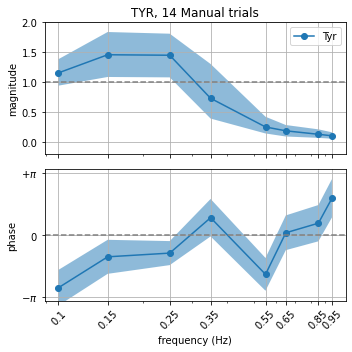

In [65]:
fig, axs = plt.subplots(2,1, figsize = (5,5),sharex = 'col', sharey = 'row')
xlim = (0,21*base_freq)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']
xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)

# magnitude
old_F = np.abs(TYR_manual)
q25,q50,q75 = np.quantile(old_F,[0.25,0.5,0.75],axis = (0,1))

# plot magnitude
ax = axs[0]
ax.plot(stimulated_freq,q50,'-o',label = 'Tyr')
ax.fill_between(stimulated_freq,q25,q75,alpha = 0.5)
ax.axhline(1,color = 'grey',linestyle = '--')
# ax.plot(stimulated_freq,np.abs(1/M_h[stimulated_index]),'--o',color = 'grey',label =r'$M^{-1}$')
# ax.set_xlim(xlim)
ax.set_xscale("log")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.set_ylim(-0.2,2)
ax.set_ylabel('magnitude')
ax.grid('on',zorder=-1)
ax.legend()

# phase
old_F = np.exp(1j*np.angle(TYR_manual))
z = np.mean(old_F,axis = (0,1))
mean = np.angle(z)
disp = 1 - np.abs(z)

# plot phase
ax = axs[1]
ax.plot(stimulated_freq,mean,'-o',label = 'Tyr')
ax.fill_between(stimulated_freq,mean+disp,mean-disp,alpha = 0.5)
ax.axhline(0,color = 'grey',linestyle = '--')
# ax.plot(stimulated_freq,np.angle(1/M_h[stimulated_index]),'--o',color = 'grey',label =r'$M^{-1}$')
# ax.set_xlim(xlim)
ax.set_xscale("log")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.set_ylim(ylimphase)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase')
# ax.set_xscale("log")
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.grid('on',zorder=-1)
# ax.legend()

axs[0].set_title('TYR, 14 Manual trials')
plt.tight_layout()
plt.show()

### Bode plot of Tyr, EMG (task performance)

In [73]:
TYR_emg = []
for p in range(participants_num):
    # stack condition
    both_cond = np.vstack((TYR['subject'+str(p)]['condition'+str(1)],TYR['subject'+str(p)]['condition'+str(6)]))
    TYR_emg.append(both_cond)
TYR_emg = np.array(TYR_emg)
print(TYR_emg.shape) # subjects x total # of half trials x stim freqs

(15, 7, 8)


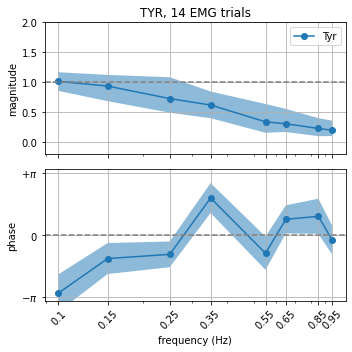

In [74]:
fig, axs = plt.subplots(2,1, figsize = (5,5),sharex = 'col', sharey = 'row')
xlim = (0,21*base_freq)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']
xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)

# magnitude
old_F = np.abs(TYR_emg)
q25,q50,q75 = np.quantile(old_F,[0.25,0.5,0.75],axis = (0,1))

# plot magnitude
ax = axs[0]
ax.plot(stimulated_freq,q50,'-o',label = 'Tyr')
ax.fill_between(stimulated_freq,q25,q75,alpha = 0.5)
ax.axhline(1,color = 'grey',linestyle = '--')
# ax.plot(stimulated_freq,np.abs(1/M_h[stimulated_index]),'--o',color = 'grey',label =r'$M^{-1}$')
# ax.set_xlim(xlim)
ax.set_xscale("log")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.set_ylim(-0.2,2)
ax.set_ylabel('magnitude')
ax.grid('on',zorder=-1)
ax.legend()

# phase
old_F = np.exp(1j*np.angle(TYR_emg))
z = np.mean(old_F,axis = (0,1))
mean = np.angle(z)
disp = 1 - np.abs(z)

# plot phase
ax = axs[1]
ax.plot(stimulated_freq,mean,'-o',label = 'Tyr')
ax.fill_between(stimulated_freq,mean+disp,mean-disp,alpha = 0.5)
ax.axhline(0,color = 'grey',linestyle = '--')
# ax.plot(stimulated_freq,np.angle(1/M_h[stimulated_index]),'--o',color = 'grey',label =r'$M^{-1}$')
# ax.set_xlim(xlim)
ax.set_xscale("log")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.set_ylim(ylimphase)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase')
# ax.set_xscale("log")
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.grid('on',zorder=-1)
# ax.legend()

axs[0].set_title('TYR, 14 EMG trials')
plt.tight_layout()
plt.show()

## F & B

In [14]:
def F_B(Tur,Tud,trialnum):
  F = np.zeros((math.ceil(trialnum/2),8), dtype=complex) #number of stimulated freqs = 8
  B = np.zeros((math.ceil(trialnum/2),8), dtype=complex)
  for i in range(math.ceil(trialnum/2)):
    for w in range(8): #number of stimulated freq
      B[i][w] = - (1 / M_h[stimulated_index][w]) * (Tud[i][w] / (1+ Tud[i][w])) 
      F[i][w] = (1 + B[i][w] * M_h[stimulated_index][w])*Tur[i][w] - B[i][w]
  return F,B

def F_B_individual(Tur,Tud,trialnum,weight): # F & B of individual modality, F0 or F1
  F = np.zeros((math.ceil(trialnum/2),8), dtype=complex) #number of stimulated freqs = 8
  B = np.zeros((math.ceil(trialnum/2),8), dtype=complex)
  for i in range(math.ceil(trialnum/2)):
    for w in range(8): #number of stimulated freq
      B[i][w] = - (1 / M_h[stimulated_index][w]) * (Tud[i][w] / (1+ weight*Tud[i][w]) ) 
      F[i][w] = (1 + weight* B[i][w] * M_h[stimulated_index][w])*Tur[i][w] - B[i][w]
  return F,B

# def F_B(Tur,Tud,trialnum):
#   F = np.zeros((math.ceil(trialnum/2),8), dtype=complex) #number of stimulated freqs = 8
#   B = np.zeros((math.ceil(trialnum/2),8), dtype=complex)
#   for i in range(math.ceil(trialnum/2)):
#     B[i] = - (1 / M_h[stimulated_index]) * (Tud[i] / (1+ Tud[i])) 
#     F[i] = (1 + B[i] * M_h[stimulated_index])*Tur[i] - B[i]
#   return F,B

In [15]:
F = {}; B = {}
for p in range(participants_num): # number of participants = 15
    F['subject'+str(p)] = {}
    B['subject'+str(p)] = {}
    for c in range(num_cond):  # number of conditions  = 7
        F['subject'+str(p)]['condition'+str(c)], B['subject'+str(p)]['condition'+str(c)] = F_B(TUR['subject'+str(p)]['condition'+str(c)],
                                                                                               TUD['subject'+str(p)]['condition'+str(c)],
                                                                                               trialnum[c])
alphas = [0,1,0.5,0.25,0.75,0,1]
F0 = {}; B0 = {}
for p in range(participants_num): # number of participants = 15
    F0['subject'+str(p)] = {}
    B0['subject'+str(p)] = {}
    for c in range(num_cond):  # number of conditions  = 7
        F0['subject'+str(p)]['condition'+str(c)], B0['subject'+str(p)]['condition'+str(c)] = F_B_individual(TU0R['subject'+str(p)]['condition'+str(c)],
                                                                                               TU0D['subject'+str(p)]['condition'+str(c)], 
                                                                                               trialnum[c],alphas[c])
one_minus_alphas = [1,0,0.5,0.75,0.25,1,0]
F1 = {}; B1 = {}
for p in range(participants_num): # number of participants = 15
    F1['subject'+str(p)] = {}
    B1['subject'+str(p)] = {}
    for c in range(num_cond):  # number of conditions  = 7
        F1['subject'+str(p)]['condition'+str(c)], B1['subject'+str(p)]['condition'+str(c)] = F_B_individual(TU1R['subject'+str(p)]['condition'+str(c)],
                                                                                               TU1D['subject'+str(p)]['condition'+str(c)],
                                                                                               trialnum[c],one_minus_alphas[c])

## new F & B (manual / EMG single tasks)

Trial 0, 2, 4, 6 ... has reference at stimuli prime*[ 3, 7, 13, 19] (index 1,3,5,7 of stimulated_index=[ 4,  6, 10, 14, 22, 26, 34, 38]);

Trial 0, 2, 4, 6 ... has disturbnace at stimuli prime*[ 2, 5, 11, 17] (index 0,2,4,6 of stimulated_index=[ 4,  6, 10, 14, 22, 26, 34, 38]).


And for 



Trial 1, 3, 5, 7 ... has reference at stimuli prime*[ 2, 5, 11, 17] (index 0,2,4,6 of stimulated_index=[ 4,  6, 10, 14, 22, 26, 34, 38])


Trial 1, 3, 5, 7 ... has disturbnace at stimuli prime*[ 3, 7, 13, 19] (index 1,3,5,7 of stimulated_index=[ 4,  6, 10, 14, 22, 26, 34, 38])

### check stimulated freqs

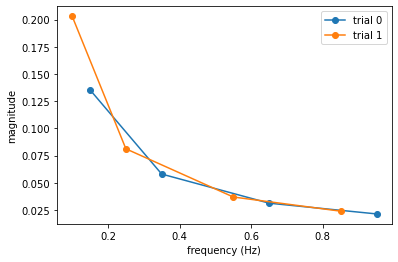

In [16]:
Even_index = np.array([ 6, 14, 26, 38])
Odd_index = np.array([ 4, 10, 22, 34])

r = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][0][Even_index] / scaleOutputScreen
plt.plot(stimulated_freq[1::2],np.abs(r),'-o',label='trial 0') # trial 0, 2, 4, 6 ... are EO trials (ref at stimuli 1,3,5...)
r = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][1][Odd_index] / scaleOutputScreen
plt.plot(stimulated_freq[::2],np.abs(r),'-o',label='trial 1') #  trial 1,3,5,7 ... are OE trials (ref at stimuli 0,2,4...)
plt.ylabel('magnitude')
plt.xlabel('frequency (Hz)')
plt.legend()
plt.show()

### manual (single modality)

In [77]:
np.abs(tur)

7.427130824027982e-15

In [78]:
np.abs(tuy)

8.028934855567703

In [85]:
FF_manual_new = []
FB_manual_new = []
for p in range(participants_num): # all subjects
    ff_ = []
    fb_ = []
    for c in [0,5]: #condition 0, 10 trials & condition 5, 4 trials
        for trial_idx in range(trialnum[c]):
            ff = []
            fb = []
            for f in stimulated_index:
                # # reference signal is zero if not at the stimulus frequency
                # if (trial_idx % 2) == 0: # trial 0, 2, 4 ...
                #     if f in Even_index:
                #         r = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][trial_idx][f] / scaleOutputScreen
                #     else:
                #         r = 0
                # else: # trial 1, 3, 5 ...
                #     if f in Odd_index:
                #         r = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][trial_idx][f] / scaleOutputScreen
                #     else:
                #         r = 0
                r = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][trial_idx][f] / scaleOutputScreen
                y = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Y'][trial_idx][f] / scaleOutputScreen
                u = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][trial_idx][f] / scaleInput
                ry = np.vstack((r,y)) # (2x1)
                A = u[np.newaxis] @ np.linalg.pinv(ry) # (1x1) @ (1x2) = (1x2)
                tur = A[0]
                tuy = A[1]

                ff.append(tur + tuy)
                fb.append(-tuy)
            ff = np.asarray(ff)
            fb = np.asarray(fb)

            # only keep ff at the reference stimuli, make the rest nan values (at non-ref stimuli, tur is not defined)
            if (trial_idx % 2) == 0: # trial 0, 2, 4 ... has ref at index 1,3,5,7
                ff[::2] = np.nan
            else: # trial 1, 3, 5 ...has ref at index 0,2,4,6
                ff[1::2] = np.nan      

            ff_.append(ff)
            fb_.append(fb)
    FF_manual_new.append(ff_)
    FB_manual_new.append(fb_)
FF_manual_new = np.asarray(FF_manual_new)
FB_manual_new = np.asarray(FB_manual_new)
print(FF_manual_new.shape) # subjects x total trials x freqs
print(FB_manual_new.shape) # subjects x total trials x freqs

(15, 14, 8)
(15, 14, 8)


In [86]:
F['subject'+str(0)]['condition'+str(0)].shape # 5 pairs of trials x 8 stim freq

(5, 8)

In [87]:
FF_manual = []
for p in range(participants_num):
    # stack condition 0 & 5
    both_cond = np.vstack((F['subject'+str(p)]['condition'+str(0)],F['subject'+str(p)]['condition'+str(5)]))
    FF_manual.append(both_cond)
FF_manual = np.array(FF_manual)
print(FF_manual.shape) # subjects x total # of half trials x stim freqs

FB_manual = []
for p in range(participants_num):
    # stack condition 0 & 5
    both_cond = np.vstack((B['subject'+str(p)]['condition'+str(0)],B['subject'+str(p)]['condition'+str(5)]))
    FB_manual.append(both_cond)
FB_manual = np.array(FB_manual)
print(FB_manual.shape) # subjects x total # of half trials x stim freqs

(15, 7, 8)
(15, 7, 8)


#### plot FF manual (old method vs new)

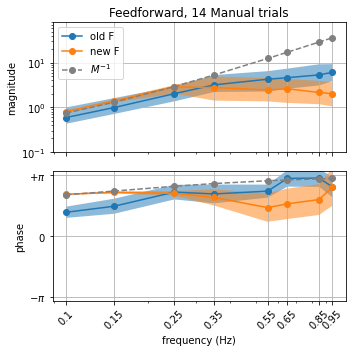

In [88]:
fig, axs = plt.subplots(2,1, figsize = (5,5),sharex = 'col', sharey = 'row')
xlim = (0,21*base_freq)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']
xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)

# magnitude
old_F = np.abs(FF_manual)
new_F = np.abs(FF_manual_new)
# new_F = np.abs(FF_manual_new[:,:,stimulated_index])
q25,q50,q75 = np.quantile(old_F,[0.25,0.5,0.75],axis = (0,1))
q25_new,q50_new,q75_new = np.nanquantile(new_F,[0.25,0.5,0.75],axis = (0,1))

# plot magnitude
ax = axs[0]
ax.plot(stimulated_freq,q50,'-o',label = 'old F')
ax.fill_between(stimulated_freq,q25,q75,alpha = 0.5)
ax.plot(stimulated_freq,q50_new,'-o',label = 'new F')
ax.fill_between(stimulated_freq,q25_new,q75_new,alpha = 0.5)
ax.plot(stimulated_freq,np.abs(1/M_h[stimulated_index]),'--o',color = 'grey',label =r'$M^{-1}$')
# ax.set_xlim(xlim)
ax.set_xscale("log")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.set_yscale("log")
ax.set_ylim(0.1,80)
ax.set_ylabel('magnitude')
ax.grid('on',zorder=-1)
ax.legend()

# phase
old_F = np.exp(1j*np.angle(FF_manual))
new_F = np.exp(1j*np.angle(FF_manual_new))
z = np.mean(old_F,axis = (0,1))
z_new = np.nanmean(new_F,axis = (0,1))
mean = np.angle(z)
mean_new = np.angle(z_new)
disp = 1 - np.abs(z)
disp_new = 1 - np.abs(z_new)

# plot phase
ax = axs[1]
ax.plot(stimulated_freq,mean,'-o',label = 'old F')
ax.fill_between(stimulated_freq,mean+disp,mean-disp,alpha = 0.5)
ax.plot(stimulated_freq,mean_new,'-o',label = 'new F')
ax.fill_between(stimulated_freq,mean_new+disp_new,mean_new-disp_new,alpha = 0.5)
ax.plot(stimulated_freq,np.angle(1/M_h[stimulated_index]),'--o',color = 'grey',label =r'$M^{-1}$')
# ax.set_xlim(xlim)
ax.set_xscale("log")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.set_ylim(ylimphase)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase')
# ax.set_xscale("log")
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.grid('on',zorder=-1)
# ax.legend()

axs[0].set_title('Feedforward, 14 Manual trials')
plt.tight_layout()
plt.show()

In [51]:
# # plot phase (just angle)
# ax = axs[1]
# ax.plot(stimulated_freq,q50,'-o',label = 'old F')
# ax.fill_between(stimulated_freq,q25,q75,alpha = 0.5)
# ax.plot(stimulated_freq,q50_new,'-o',label = 'new F')
# ax.fill_between(stimulated_freq,q25_new,q75_new,alpha = 0.5)
# ax.plot(stimulated_freq,np.angle(1/M_h[stimulated_index]),'--o',color = 'grey',label =r'$M^{-1}$')
# # ax.set_xlim(xlim)
# ax.set_xscale("log")
# ax.set_xticks(xticks)
# ax.set_xticklabels(xticklabels,rotation=45)
# ax.set_ylim(ylimphase)
# ax.set_xlabel('frequency (Hz)')
# ax.set_ylabel('phase')
# # ax.set_xscale("log")
# ax.set_yticks(yticksphase)
# ax.set_yticklabels(yticklabelsphase)
# ax.grid('on',zorder=-1)
# # ax.legend()

#### plot FB manual

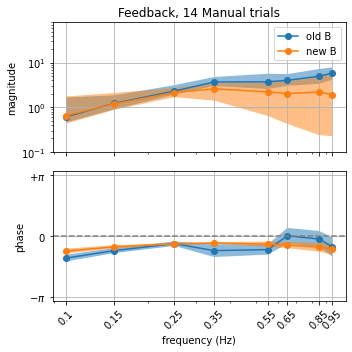

In [70]:
fig, axs = plt.subplots(2,1, figsize = (5,5),sharex = 'col', sharey = 'row')
xlim = (0,21*base_freq)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']
xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)

# magnitude
old_B = np.abs(FB_manual)
new_B = np.abs(FB_manual_new)
q25,q50,q75 = np.quantile(old_B,[0.25,0.5,0.75],axis = (0,1))
q25_new,q50_new,q75_new = np.nanquantile(new_B,[0.25,0.5,0.75],axis = (0,1))

# plot magnitude
ax = axs[0]
ax.plot(stimulated_freq,q50,'-o',label = 'old B')
ax.fill_between(stimulated_freq,q25,q75,alpha = 0.5)
ax.plot(stimulated_freq,q50_new,'-o',label = 'new B')
ax.fill_between(stimulated_freq,q25_new,q75_new,alpha = 0.5)
# ax.set_xlim(xlim)
ax.set_xscale("log")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.set_yscale("log")
ax.set_ylim(0.1,80)
ax.set_ylabel('magnitude')
ax.grid('on',zorder=-1)
ax.legend()

# phase
old_B = np.exp(1j*np.angle(FB_manual))
new_B = np.exp(1j*np.angle(FB_manual_new))
z = np.mean(old_B,axis = (0,1))
z_new = np.nanmean(new_B,axis = (0,1))
mean = np.angle(z)
mean_new = np.angle(z_new)
disp = 1 - np.abs(z)
disp_new = 1 - np.abs(z_new)

# plot phase
ax = axs[1]
ax.plot(stimulated_freq,mean,'-o',label = 'old B')
ax.fill_between(stimulated_freq,mean+disp,mean-disp,alpha = 0.5)
ax.plot(stimulated_freq,mean_new,'-o',label = 'new B')
ax.fill_between(stimulated_freq,mean_new+disp_new,mean_new-disp_new,alpha = 0.5)
ax.axhline(y = 0,linestyle = '--',color = 'grey')
# ax.set_xlim(xlim)
ax.set_xscale("log")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.set_ylim(ylimphase)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase')
# ax.set_xscale("log")
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.grid('on',zorder=-1)
# ax.legend()

axs[0].set_title('Feedback, 14 Manual trials')
plt.tight_layout()
plt.show()

### EMG (single modality)

In [55]:
FF_emg_new = []
FB_emg_new = []
for p in range(participants_num): # all subjects
    ff_ = []
    fb_ = []
    for c in [1,6]: #condition 1, 10 trials & condition 6, 4 trials
        for trial_idx in range(trialnum[c]):
            ff = []
            fb = []
            for f in stimulated_index:
                # # reference signal is zero if not at the stimulus frequency
                # if (trial_idx % 2) == 0: # trial 0, 2, 4 ...
                #     if f in Even_index:
                #         r = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][trial_idx][f] / scaleOutputScreen
                #     else:
                #         r = 0
                # else: # trial 1, 3, 5 ...
                #     if f in Odd_index:
                #         r = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][trial_idx][f] / scaleOutputScreen
                #     else:
                #         r = 0
                r = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['R'][trial_idx][f] / scaleOutputScreen
                y = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['Y'][trial_idx][f] / scaleOutputScreen
                u = DATA['FREQ']['subject'+str(p)]['condition'+str(c)]['U'][trial_idx][f] / scaleInput
                ry = np.vstack((r,y)) # (2x1)
                A = u[np.newaxis] @ np.linalg.pinv(ry) # (1x1) @ (1x2) = (1x2)
                tur = A[0]
                tuy = A[1]

                ff.append(tur + tuy)
                fb.append(-tuy)
            ff = np.asarray(ff)
            fb = np.asarray(fb)
            
            # only keep ff at the reference stimuli, make the rest nan values
            if (trial_idx % 2) == 0: # trial 0, 2, 4 ... has ref at index 1,3,5,7
                ff[::2] = np.nan
            else: # trial 1, 3, 5 ...has ref at index 0,2,4,6
                ff[1::2] = np.nan   
                
            ff_.append(ff)
            fb_.append(fb)
    FF_emg_new.append(ff_)
    FB_emg_new.append(fb_)
FF_emg_new = np.asarray(FF_emg_new)
FB_emg_new = np.asarray(FB_emg_new)
print(FF_emg_new.shape) # subjects x total trials x freqs
print(FB_emg_new.shape) # subjects x total trials x freqs

(15, 14, 8)
(15, 14, 8)


In [56]:
FF_emg = []
for p in range(participants_num):
    # stack condition 
    both_cond = np.vstack((F['subject'+str(p)]['condition'+str(1)],F['subject'+str(p)]['condition'+str(6)]))
    FF_emg.append(both_cond)
FF_emg = np.array(FF_emg)
print(FF_emg.shape) # subjects x total # of half trials x stim freqs

FB_emg = []
for p in range(participants_num):
    # stack condition 
    both_cond = np.vstack((B['subject'+str(p)]['condition'+str(1)],B['subject'+str(p)]['condition'+str(6)]))
    FB_emg.append(both_cond)
FB_emg = np.array(FB_emg)
print(FB_emg.shape) # subjects x total # of half trials x stim freqs

(15, 7, 8)
(15, 7, 8)


#### plot FF emg (old vs new)

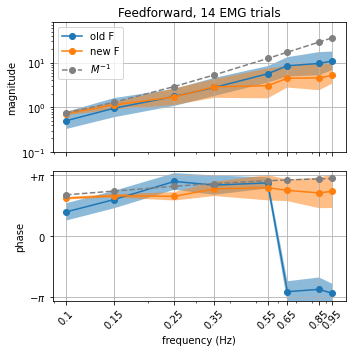

In [71]:
fig, axs = plt.subplots(2,1, figsize = (5,5),sharex = 'col', sharey = 'row')
xlim = (0,21*base_freq)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']
xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)

# magnitude
old_F = np.abs(FF_emg)
new_F = np.abs(FF_emg_new)
q25,q50,q75 = np.quantile(old_F,[0.25,0.5,0.75],axis = (0,1))
q25_new,q50_new,q75_new = np.nanquantile(new_F,[0.25,0.5,0.75],axis = (0,1))

# plot magnitude
ax = axs[0]
ax.plot(stimulated_freq,q50,'-o',label = 'old F')
ax.fill_between(stimulated_freq,q25,q75,alpha = 0.5)
ax.plot(stimulated_freq,q50_new,'-o',label = 'new F')
ax.fill_between(stimulated_freq,q25_new,q75_new,alpha = 0.5)
ax.plot(stimulated_freq,np.abs(1/M_h[stimulated_index]),'--o',color = 'grey',label =r'$M^{-1}$')
# ax.set_xlim(xlim)
ax.set_xscale("log")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.set_yscale("log")
ax.set_ylim(0.1,80)
ax.set_ylabel('magnitude')
ax.grid('on',zorder=-1)
ax.legend()

# phase
old_F = np.exp(1j*np.angle(FF_emg))
new_F = np.exp(1j*np.angle(FF_emg_new))
z = np.mean(old_F,axis = (0,1))
z_new = np.nanmean(new_F,axis = (0,1))
mean = np.angle(z)
mean_new = np.angle(z_new)
disp = 1 - np.abs(z)
disp_new = 1 - np.abs(z_new)

# plot phase
ax = axs[1]
ax.plot(stimulated_freq,mean,'-o',label = 'old F')
ax.fill_between(stimulated_freq,mean+disp,mean-disp,alpha = 0.5)
ax.plot(stimulated_freq,mean_new,'-o',label = 'new F')
ax.fill_between(stimulated_freq,mean_new+disp_new,mean_new-disp_new,alpha = 0.5)
ax.plot(stimulated_freq,np.angle(1/M_h[stimulated_index]),'--o',color = 'grey',label =r'$M^{-1}$')
# ax.set_xlim(xlim)
ax.set_xscale("log")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.set_ylim(ylimphase)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase')
# ax.set_xscale("log")
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.grid('on',zorder=-1)
# ax.legend()

axs[0].set_title('Feedforward, 14 EMG trials')
plt.tight_layout()
plt.show()

#### plot FB emg

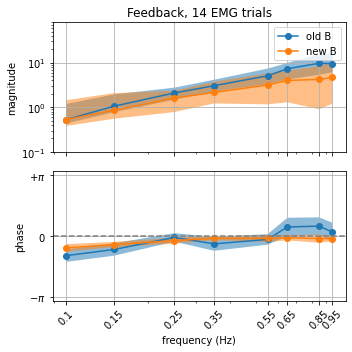

In [72]:
fig, axs = plt.subplots(2,1, figsize = (5,5),sharex = 'col', sharey = 'row')
xlim = (0,21*base_freq)
ylimphase = (-np.pi-0.2,np.pi+ 0.2)
yticksphase = [-np.pi,0.,np.pi]
yticklabelsphase = [r'$-\pi$',r'$0$',r'$+\pi$']
xticks = prime*0.05
xticklabels =np.round(prime*0.05,2)

# magnitude
old_B = np.abs(FB_emg)
new_B = np.abs(FB_emg_new)
q25,q50,q75 = np.quantile(old_B,[0.25,0.5,0.75],axis = (0,1))
q25_new,q50_new,q75_new = np.nanquantile(new_B,[0.25,0.5,0.75],axis = (0,1))

# plot magnitude
ax = axs[0]
ax.plot(stimulated_freq,q50,'-o',label = 'old B')
ax.fill_between(stimulated_freq,q25,q75,alpha = 0.5)
ax.plot(stimulated_freq,q50_new,'-o',label = 'new B')
ax.fill_between(stimulated_freq,q25_new,q75_new,alpha = 0.5)
# ax.set_xlim(xlim)
ax.set_xscale("log")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.set_yscale("log")
ax.set_ylim(0.1,80)
ax.set_ylabel('magnitude')
ax.grid('on',zorder=-1)
ax.legend()

# phase
old_B = np.exp(1j*np.angle(FB_emg))
new_B = np.exp(1j*np.angle(FB_emg_new))
z = np.mean(old_B,axis = (0,1))
z_new = np.nanmean(new_B,axis = (0,1))
mean = np.angle(z)
mean_new = np.angle(z_new)
disp = 1 - np.abs(z)
disp_new = 1 - np.abs(z_new)

# plot phase
ax = axs[1]
ax.plot(stimulated_freq,mean,'-o',label = 'old B')
ax.fill_between(stimulated_freq,mean+disp,mean-disp,alpha = 0.5)
ax.plot(stimulated_freq,mean_new,'-o',label = 'new B')
ax.fill_between(stimulated_freq,mean_new+disp_new,mean_new-disp_new,alpha = 0.5)
ax.axhline(y = 0,linestyle = '--',color = 'grey')
# ax.set_xlim(xlim)
ax.set_xscale("log")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation=45)
ax.set_ylim(ylimphase)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase')
# ax.set_xscale("log")
ax.set_yticks(yticksphase)
ax.set_yticklabels(yticklabelsphase)
ax.grid('on',zorder=-1)
# ax.legend()

axs[0].set_title('Feedback, 14 EMG trials')
plt.tight_layout()
plt.show()

#### check phase

(-20.0, 20.0)

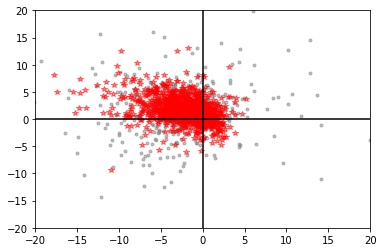

In [27]:
for p in range(participants_num):
    for trial_idx in range(7):
        plt.plot(FF_manual[p,trial_idx,:].real,FF_manual[p,trial_idx,:].imag,'.',label='old_B',color = 'grey',alpha = 0.5)
for p in range(participants_num):
    for trial_idx in range(14):
        plt.plot(FF_manual_new[p,trial_idx,:].real,FF_manual_new[p,trial_idx,:].imag,'*',label='new_B',color = 'red',alpha = 0.5)
plt.axvline(x=0,color='black')
plt.axhline(y=0,color='black')
plt.xlim([-20,20])
plt.ylim([-20,20])

(-20.0, 20.0)

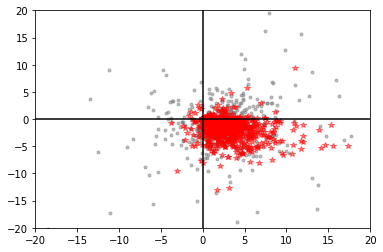

In [28]:
for p in range(participants_num):
    for trial_idx in range(7):
        plt.plot(FB_manual[p,trial_idx,:].real,FB_manual[p,trial_idx,:].imag,'.',label='old_B',color = 'grey',alpha = 0.5)
for p in range(participants_num):
    for trial_idx in range(14):
        plt.plot(FB_manual_new[p,trial_idx,:].real,FB_manual_new[p,trial_idx,:].imag,'*',label='new_B',color = 'red',alpha = 0.5)
plt.axvline(x=0,color='black')
plt.axhline(y=0,color='black')
plt.xlim([-20,20])
plt.ylim([-20,20])

Text(0.5, 1.0, 'Feedback, EMG')

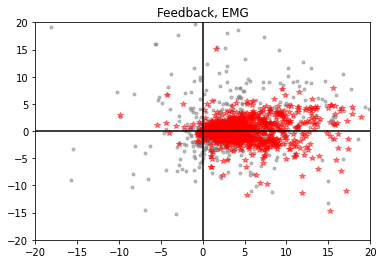

In [29]:
for p in range(participants_num):
    for trial_idx in range(7):
        plt.plot(FB_emg[p,trial_idx,:].real,FB_emg[p,trial_idx,:].imag,'.',label='old_B',color = 'grey',alpha = 0.5)
for p in range(participants_num):
    for trial_idx in range(14):
        plt.plot(FB_emg_new[p,trial_idx,:].real,FB_emg_new[p,trial_idx,:].imag,'*',label='new_B',color = 'red',alpha = 0.5)
plt.axvline(x=0,color='black')
plt.axhline(y=0,color='black')
plt.xlim([-20,20])
plt.ylim([-20,20])
plt.title('Feedback, EMG')